## Imports

In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import json
import numpy as np
from scipy.optimize import curve_fit
from random import randrange
from itertools import count

# Experiment Loading Functions

In [2]:
def load_jsons(jsons_path, json_files):
    jsons = {}
    
    for subdir, dirs, files in os.walk(jsons_path):
        for file in files:
            for json_file in json_files:
                if file == json_file + ".json":
                    with open(os.path.join(subdir, file), 'r') as f:
                        assert json_file not in jsons, jsons_path + json_file
                        jsons[json_file] = json.load(f)
                        
    return jsons

In [3]:
def flatten_dictionary(dictionary):
    return pd.io.json.json_normalize(dictionary).to_dict(orient='records')[0]

In [4]:
def load_experiment(experiment_path, attack_folder_include, verbose):
    if verbose:
        print(experiment_path)
    experiment = {}
    
    target_jsons = ["metrics_train", "metrics_test", "training", "parameters"]
    attack_jsons = ["attack_parameters", "combined_metrics"]
    
    target_folders = [ f.name for f in os.scandir(experiment_path) if f.is_dir() and f.name.startswith('target')]
    attack_folders = [ f.name for f in os.scandir(experiment_path) if f.is_dir() and f.name.startswith(attack_folder_include or "attack")]
    
    if len(attack_folders) == 0:
        print(f"Attention: 0 attack_folders found for {attack_folder_include} in {experiment_path}")
        attack_folders = [ f.name for f in os.scandir(experiment_path) if f.is_dir() and f.name.startswith("attack")]
    
    target_folders.sort()
    attack_folders.sort()
    
    if verbose:
        print(target_folders)
        print(attack_folders)
    
    for idx in range(len(target_folders)):
        experiment[idx] = {}
        experiment[idx]['target'] = load_jsons(os.path.join(experiment_path, target_folders[idx]), target_jsons)
        
        test_metrics = flatten_dictionary(experiment[idx]['target']['metrics_test'])
        train_metrics = flatten_dictionary(experiment[idx]['target']['metrics_train'])
        test_metrics = pd.DataFrame.from_dict(test_metrics, orient='index')
        train_metrics = pd.DataFrame.from_dict(train_metrics, orient='index')
        gap_metrics = train_metrics - test_metrics
        
        experiment[idx]['target']['gap_metrics'] = gap_metrics.to_dict()[0]
        
        experiment[idx] = flatten_dictionary(experiment[idx])

        experiment[idx]['target.gap_metrics.loss_gap'] = \
            experiment[idx]['target.metrics_test.loss'] / experiment[idx]['target.metrics_train.loss']
    
    for idx in range(len(attack_folders)):
        if verbose:
            print(attack_folders[idx])
        experiment[idx + len(target_folders)] = {}
        experiment[idx + len(target_folders)]['attacker'] = (load_jsons(os.path.join(experiment_path, attack_folders[idx]), attack_jsons))
        experiment[idx + len(target_folders)] = flatten_dictionary(experiment[idx + len(target_folders)])
        
    experiment_df = pd.DataFrame.from_dict(experiment, orient='index')
    
    parameters = [parameter for parameter in list(experiment_df.columns) 
              if "parameter" in parameter 
                  and not "seed" in parameter 
                  and not "path" in parameter
                  and not "save_model_freq" in parameter
                  and not "target_model_stacking" in parameter
                  and not "experiment_name" in parameter]
    for parameter in parameters:
        try:
            assert len(experiment_df[parameter].unique()) <= 2, parameter + " is not always the same!"
        except TypeError:
            pass

    # Check if right number of experiments is there
    if len(target_folders) != 1:
        print(f"Averaging {experiment_path.split('/')[-3:]} targets over {len(target_folders)} runs!")
    if len(attack_folders) != 1:
        print(f"Averaging {experiment_path.split('/')[-3:]} attacks over {len(attack_folders)} runs!")
        
    experiment = experiment_df.iloc[0].to_dict()
    experiment.update(experiment_df.mean().to_dict())
    
    return experiment

In [5]:
def load_experiments_folder(path, attack_folder_include=None, verbose=False):
    experiments = {}
    
    subfolders = [ f.name for f in os.scandir(path) if f.is_dir() ]
    
    for subfolder in subfolders:
        if subfolder.startswith("target") or subfolder.startswith("attack"):
            return load_experiment(path, attack_folder_include, verbose)
            
    for subfolder in subfolders:
        if "_" not in subfolder:
            experiments[subfolder] = load_experiments_folder(os.path.join(path, subfolder), attack_folder_include, verbose)
    
    return experiments

In [6]:
bestbuy_experiments_bow = load_experiments_folder('/mnt/efs/DPTextHierarchy/logs/bestbuy_ratio/BasicClf')

/home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  


### Combine dataframes

In [7]:
def get_dataframe_for_model(model_dict, warn=True):
    
    dataframe_list = []
    
    for train_size in model_dict:
        train_size_experiments_dict = model_dict[train_size]
        dataframe_list.append(pd.DataFrame.from_dict(train_size_experiments_dict, orient='index'))
    
    # Concat relevant rows
    dataset_df = pd.concat(dataframe_list, sort=False)

    return dataset_df

# Experiment Loading

#### BestBuy

In [8]:
bestbuy_experiments_bow = load_experiments_folder('/mnt/efs/DPTextHierarchy/logs/bestbuy_ratio/BasicClf')
bestbuy_df_bow = get_dataframe_for_model(bestbuy_experiments_bow)

/home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  


In [9]:
bestbuy_experiments_bert = load_experiments_folder('/mnt/efs/DPTextHierarchy/logs/bestbuy_ratio/bert-base-uncased')
bestbuy_df_bert = get_dataframe_for_model(bestbuy_experiments_bert)

/home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  


#### DBPedia

In [11]:
def load_experiments_folder_three(path, attack_folder_include=None, verbose=False):
    experiments = {}
    
    subfolders = [ f.name for f in os.scandir(path) if f.is_dir() ]
    
    for subfolder in subfolders:
        if subfolder.startswith("target") or subfolder.startswith("attack"):
            return load_experiment(path, attack_folder_include, verbose)
            
    for subfolder in subfolders:
        if "_" not in subfolder:
            if len(subfolder) == 1:
                experiments["3"] = load_experiments_folder_three(os.path.join(path, "3"), "attack_20", verbose)
                experiments["2"] = load_experiments_folder_three(os.path.join(path, "3"), "attack_only_use_first_2", verbose)
                experiments["1"] = load_experiments_folder_three(os.path.join(path, "3"), "attack_only_use_first_output", verbose)
            else:
                experiments[subfolder] = load_experiments_folder_three(os.path.join(path, subfolder), attack_folder_include, verbose)
    
    return experiments

In [12]:
dbpedia_experiments = load_experiments_folder_three('/mnt/efs/DPTextHierarchy/logs/dbpedia_ratio/BasicClf')
dbpedia_df = get_dataframe_for_model(dbpedia_experiments)

/home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  


In [13]:
dbpedia_df["index"] = dbpedia_df.index
dbpedia_df["target.parameters.levels"] = dbpedia_df.apply(lambda x: (x["target.parameters.levels"][:int(x["index"])]), axis=1)

### Reuters

In [14]:
reuters_experiments = load_experiments_folder('/mnt/efs/DPTextHierarchy/logs/reuters_ratio/BasicClf')
reuters_df = get_dataframe_for_model(reuters_experiments)

/home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  


# Graphs

In [15]:
def compute_r_sqared(xdata, ydata, func, popt):
    ss_tot = np.sum((ydata-np.mean(ydata))**2)
    
    residuals = ydata - func(xdata, *popt)
    ss_res = np.sum(residuals**2)

    r_squared = 1 - (ss_res / ss_tot)

    return r_squared

In [16]:
import matplotlib.ticker as plticker
import matplotlib.ticker as mtick

In [17]:
def records_levels_ratio_plot(model_df, y_metric = 'advantage'):
    # Assert only one dataset
    assert len(model_df['target.parameters.dataset'].unique()) == 1
    # Assert model df
    assert len(model_df['target.parameters.model_path'].unique()) == 1
    
    model_df['amount_of_levels'] = model_df['target.parameters.levels'].map(len)
    model_df['records/levels-ratio'] = model_df['target.parameters.train_size'] / model_df['amount_of_levels']
    
    fig, ax = plt.subplots()
    
    def func(x, a, b, c):
        return a / np.multiply(b, x) + c
    
    xdata = model_df['records/levels-ratio']
    ydata = model_df[f'attacker.combined_metrics.{y_metric}']
    
    popt, pcov = curve_fit(func, xdata, ydata)
    
    r_squared = compute_r_sqared(xdata, ydata, func, popt)
    
    ax.plot(sorted(xdata), 
                func(sorted(model_df['records/levels-ratio']), *popt), 
                linestyle='--', 
                marker='None',
                label=f'$R^2 = {r_squared:.2f}$')
    
    for amount_of_levels, marker in zip(sorted(model_df['amount_of_levels'].unique()), ['v', 'o', 'x']):
        model_df_for_level = model_df[model_df['amount_of_levels'] == amount_of_levels]
        ax.plot(model_df_for_level['records/levels-ratio'], 
                model_df_for_level[f'attacker.combined_metrics.{y_metric}'], 
                linestyle='None', 
                marker=marker,
                label=f'{amount_of_levels} ' + ("level" if amount_of_levels == 1 else "levels"))
        
    loc = plticker.MultipleLocator(base=0.05) # this locator puts ticks at regular intervals
    ax.yaxis.set_major_locator(loc)
    
    loc = plticker.FuncFormatter(lambda x, pos: (str(int(x/1e3)) + "k") if x > 0 else "0")
    ax.xaxis.set_major_formatter(loc)
        
    plt.ylabel(y_metric)
    plt.xlabel('records/levels-ratio')
    
    ax.legend()
    
    return fig
    

In [18]:
figures_to_save = {}

#### BestBuy BoW (fasttext)

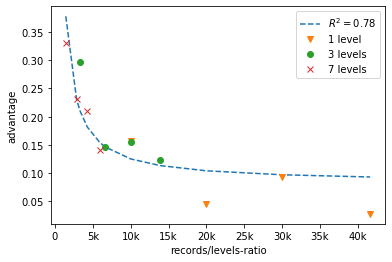

In [19]:
figures_to_save["bestbuy_bow_ratio"] = records_levels_ratio_plot(bestbuy_df_bow)

Accuracy:

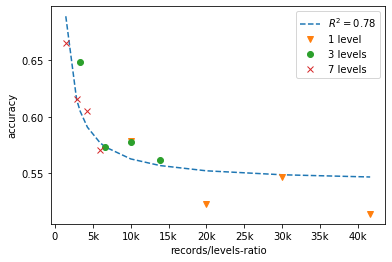

In [20]:
_ = records_levels_ratio_plot(bestbuy_df_bow, 'accuracy')

#### BestBuy BERT

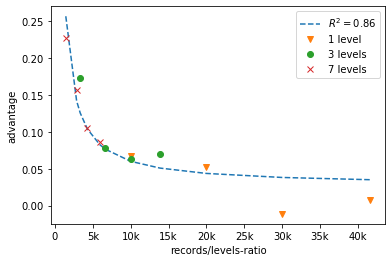

In [21]:
_ = records_levels_ratio_plot(bestbuy_df_bert)

#### DBPedia

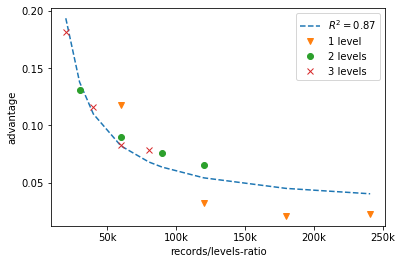

In [22]:
figures_to_save["dbpedia_bow_ratio"] = records_levels_ratio_plot(dbpedia_df)

#### Reuters

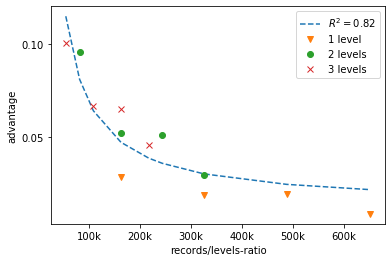

In [23]:
figures_to_save["reuters_bow_ratio"] = records_levels_ratio_plot(reuters_df)

In [24]:
from IPython.core import display as ICD

In [25]:
biggest_figure = figures_to_save["dbpedia_bow_ratio"]
bbox = biggest_figure.get_tightbbox(biggest_figure.canvas.get_renderer())

for name, figure in figures_to_save.items():
    #ICD.display(figure)
    figure.savefig(f'{name}.pdf', bbox_inches=bbox)